# Change point based Clustering

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [4]:
import sys
sys.path.append('../')

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [6]:
from eval.tsdr import load_tsdr_by_chaos

tt_dataset_by_chaos = load_tsdr_by_chaos(
    TRAINTICKET_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [376]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "orders-db")][1]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

orders-db/pod-memory-hog/9n6mf-4


((180, 1403),
 '2023-02-17-argowf-chaos-9n6mf-orders-db_pod-memory-hog_4.json of orders-db/pod-memory-hog')

In [377]:
from tsdr.outlierdetection.spot import detect_anomalies_with_spot
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma

sli_data: pd.DataFrame = dataset.loc[
    :, [col for col in record.pk.get_root_metrics() if col in dataset.columns]
]  # retrieve only existing slis
most_anomalous_sli_name = sli_data.apply(lambda x: detect_anomalies_with_spot(x.to_numpy(), 4*30)[1]).idxmax()
most_anomalous_sli_data = sli_data[most_anomalous_sli_name].to_numpy()
most_anomalous_sli_name 

's-front-end_latency'

In [378]:
cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cols]

In [379]:
from tsdr.multireducer import change_point_clustering, change_point_clustering_with_kde
from tsdr.smooth import moving_average

In [380]:
# from tsdr import tsdr

# tsdr.Tsdr(enable_unireducer=False, enable_multireducer=True, univariate_series_func_or_name="residual_integral",
#     step2_clustering_method_name="changepoint",
#     step2_changepoint_n_bkps=1,
#     step2_changepoint_proba_threshold=0.5,
#     step2_clustering_choice_method="max_members_changepoint",
#     step2_changepoint_cluster_selection_method="leaf",
#     step2_changepoint_cluster_selection_epsilon=3.0,
#     step2_changepoint_allow_single_cluster=True,
#     step2_clustering_n_workers=1,
# ).reduce_multivariate_series(
#     dataset,
#     record.pk,
#     n_workers=1,
# )

In [381]:
# cinfo, remove_metrics = change_point_clustering(
#     cause_dataset,
#     n_bkps=1,
#     proba_threshold=0.5,
#     choice_method="max_members_changepoint",
#     cluster_selection_epsilon=3.0,
#     cluster_selection_method="leaf",
#     cluster_allow_single_cluster=True,
#     sli_data=sli_data,
#     n_jobs=-1,
# )
cinfo, remove_metrics = change_point_clustering_with_kde(
    cause_dataset,
    cost_model="l2",
    n_bkps=1,
    kde_bandwidth=0.1,
    n_jobs=-1,
)
cinfo, remove_metrics

({'m-orders-db_mongodb_ss_wt_cursor_cursor_insert_calls': [],
  'm-orders-db_mongodb_ss_metrics_commands_getCmdLineOpts_total': [],
  'm-orders-db_mongodb_ss_catalogStats_collections': [],
  'm-orders-db_mongodb_ss_wt_reconciliation_pages_written_including_at_least_one_start_transaction_ID': [],
  'm-orders-db_mongodb_top_readLock_count': [],
  'm-orders-db_mongodb_ss_connections': [],
  'm-orders-db_mongodb_ss_mem_virtual': [],
  'm-orders-db_mongodb_ss_logicalSessionRecordCache_lastSessionsCollectionJobEntriesEnded': [],
  'm-orders-db_mongodb_ss_wt_txn_transaction_checkpoint_generation': [],
  'm-orders-db_mongodb_ss_wt_cache_pages_walked_for_eviction': [],
  'm-orders-db_mongodb_ss_wt_cache_eviction_passes_of_a_file': [],
  'm-orders-db_mongodb_ss_metrics_commands_getLastError_total': [],
  'm-orders-db_mongodb_ss_wt_cache_pages_seen_by_eviction_walk': [],
  'm-orders-db_mongodb_ss_locks_Collection_acquireCount_w': [],
  'm-orders-db_mongodb_ss_wt_cache_pages_currently_held_in_the_

In [382]:
import ruptures as rpt
import hdbscan 
from hdbscan.prediction import all_points_membership_vectors, all_points_outlier_membership_vector

from collections import defaultdict
import itertools

In [383]:
# cause_dataset = cause_dataset.apply(lambda x: moving_average(x, window_size=5))
# sli_data = sli_data.apply(lambda x: moving_average(x, window_size=5))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/ruptures/costs/costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


162

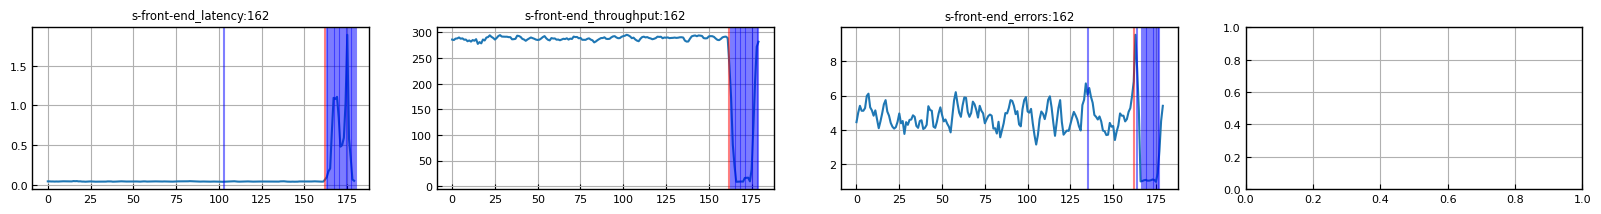

In [384]:
import math

binseg = rpt.Binseg(model="normal", jump=1)
fig, axs = plt.subplots(math.ceil(sli_data.shape[1]/4), ncols=4)
fig.set_size_inches(20, 0.7*sli_data.shape[1])
bkps = []
for ax, sli in zip(axs.flatten(), sli_data.columns):
    sli_y = sli_data[sli].values
    bkp = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[0]
    bkps.append(bkp)
    ax.plot(sli_y)
    ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(f"{sli}:{bkp}")

    backward_idx = 4*20
    alarms, scores = detect_anomalies_with_spot(sli_y, anomalous_start_idx=backward_idx, return_score=True, proba=1e-4)
    # alarms, scores = detect_anomalies_with_zscore_nsigma(sli_y, anomalous_start_idx=backward_idx, return_score=True, n_sigmas=3.0, robust=True)
    for alarm in alarms:
        a = (sli_y.size - backward_idx) + alarm
        ax.axvline(a, color='blue', alpha=0.5)
    # _bkps = binseg.fit(scipy.stats.zscore(sli_y)).predict(n_bkps=1)[:-1]
    # for bkp in _bkps:
    #     ax.axvline(bkp, color='green', alpha=0.7)
    
slis_bkp: int = binseg.fit(sli_data.apply(scipy.stats.zscore).values).predict(n_bkps=1)[0]
slis_bkp

## Change points detection

In [401]:
from tsdr.outlierdetection.n_sigma_rule import detect_anomalies_with_zscore_nsigma_causerank

data = cause_dataset
n_bkps = 1

metrics = data.columns.tolist()
change_points: list[int] = []
data_size = data.shape[0]
for metric in metrics:
    x = data[metric].to_numpy()
    anomaly, scores = detect_anomalies_with_zscore_nsigma_causerank(x, anomalous_start_idx=4*25, n_sigmas=2.0)
    # data_size = len(scores)
    # change_point = binseg.fit(scipy.stats.zscore(x)).predict(n_bkps=n_bkps)[0]
    binseg = rpt.Binseg(model="l2", jump=1)
    change_point = binseg.fit(x).predict(n_bkps=n_bkps)[0]
    change_points.append(change_point)
metric_to_bkp = {metric: bkp for metric, bkp in zip(metrics, change_points)}


In [402]:
total_bkp = rpt.Binseg(model="l2", jump=1).fit(data).predict(n_bkps=n_bkps)[0]
print(
    "multivariate bkp", total_bkp
)

multivariate bkp (161,)


## Gradient-based change point detection

In [393]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

def rollback(self):
    for x in change_points:
        index = self.data.index(x)
        while index > 0:
            tangent1 = self.data[index-1] - self.data[index]
            tangent2 = self.calculate_tangent(self.data[index-2], self.data[index-1])

            if abs(tangent1 - tangent2) < self.threshold:
                index -= 1
            else:
                break

        self.abnormal_change_points.append(self.data[index])

def critical_change_point(X, change_points):
    grad = np.abs(np.gradient(X))
    grad_max_t = np.argmax(grad)
    nearest_i = np.abs(change_points - grad_max_t).argmin()
    return change_points[nearest_i]


# for metric in data.loc[:, data.columns.str.startswith("c-orders")]:
#     x = data[metric].to_numpy()
#     anomaly, scores = detect_anomalies_with_zscore_nsigma_causerank(x, anomalous_start_idx=4*25, n_sigmas=2.0)
#     print(metric, anomaly)
#     # x_ = moving_average(x, window_size=5)

#     seg = 2
#     sigma = np.std(x)
#     aic_pen = seg*sigma*sigma
#     bic_pen = np.log(x.size) * seg * sigma * sigma
#     algo = rpt.Pelt(model="l2", jump=1)
#     change_points = np.array(algo.fit(x).predict(pen=bic_pen)[:-1], dtype=int)
#     # change_points = np.array(algo.fit(x).predict(n_bkps=1)[:-1], dtype=int)
#     # ccp = critical_change_point(x, change_points)

#     sigma = np.std(scores)
#     aic_pen = seg*sigma*sigma
#     # bic_pen = np.log(scores.size) * 2 * sigma * sigma
#     # scores_change_points = np.array(pelt.fit(scores).predict(pen=aic_pen)[:-1], dtype=int)
#     algo = rpt.Pelt(model="l2", jump=1)
#     scores_change_points = np.array(algo.fit(scores).predict(pen=aic_pen)[:-1], dtype=int)
#     max_score_i = np.argmax(scores)
#     # scores_ccp = critical_change_point(scores, scores_change_points)
#     # cp = change_points[np.argmin(np.abs(change_points - max_score_i))]    
#     # cp_j = np.argmax(scores_change_points[max_score_i])
#     # scores_cp = change_points[cp_j]
#     # gx = np.abs(np.gradient(x))
#     # change_point = np.argmax(gx)

#     fig, axs = plt.subplots(1, 2, figsize=(20, 2))
#     axs[0].plot(x)
#     axs[0].plot(change_points, x[change_points], 'o')
#     # axs[0].plot(ccp, x[ccp], 'x')
#     axs[1].plot(scores)
#     # plt.plot(cp, scores[cp], 'o')
#     axs[1].plot(scores_change_points, scores[scores_change_points], 'o')

#     bkp = rpt.Binseg(model="l2").fit(x).predict(n_bkps=1)[0]
#     axs[0].plot(bkp, x[bkp], 'x')
#     bkp = rpt.Binseg(model="l2").fit(scores).predict(n_bkps=1)[0]
#     axs[1].plot(bkp, scores[bkp], 'x')

# plt.close()

## KDE 1d clustering

[array([ 76, 293, 366]), array([ 67, 145, 332, 368, 420]), array([ 42,  84, 282]), array([150, 287, 306, 341, 375]), array([307]), array([167, 260]), array([ 27,  52, 108, 176, 181, 202, 217, 269, 272, 274, 288, 316, 318,
       362, 374, 384, 394, 419]), array([5]), array([315]), array([62]), array([310]), array([130]), array([412]), array([137, 166, 228, 397, 424]), array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  53,  54,  55,  56,
        57,  58,  59,  60,  63,  64,  65,  66,  68,  69,  70,  71,  72,
        73,  74,  75,  77,  78,  79,  80,  81,  82,  83,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 1

metric  cluster_id  \
366  m-orders-db_mongodb_ss_wt_cache_maximum_page_s...           0   
76   m-orders-db_mongodb_sys_netstat_TcpExt_TCPAuto...           0   
293  m-orders-db_mongodb_ss_wt_reconciliation_maxim...           0   
420  m-orders-db_mongodb_ss_logicalSessionRecordCac...           1   
145  m-orders-db_mongodb_ss_logicalSessionRecordCac...           1   
368  m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...           1   
67   m-orders-db_mongodb_ss_logicalSessionRecordCac...           1   
332  m-orders-db_mongodb_ss_wt_cursor_cached_cursor...           1   
84   m-orders-db_mongodb_ss_wt_txn_transaction_chec...           2   
42           m-orders-db_mongodb_sys_cpu_procs_blocked           2   
282  m-orders-db_mongodb_ss_wt_thread_state_active_...           2   
341  m-orders-db_mongodb_ss_globalLock_activeClient...           3   
287  m-orders-db_mongodb_ss_globalLock_activeClient...           3   
375  m-orders-db_mongodb_ss_wt_session_open_session...           3   
306  m-orders-db_mongodb_sys_netstat_TcpExt_TCPBack...           3   
150  m-orders-db_mongodb_ss_wt_concurrentTransactio...           3   
307  m-orders-db_mongodb_ss_wt_concurrentTransactio...           4   
260  m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...           5   
167  m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...           5   
272  m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...           6   
384  m-orders-db_mongodb_sys_mounts_etc_hosts_avail...           6   
181   m-orders-db_mongodb_sys_mounts_data_db_available           6   
27   m-orders-db_mongodb_sys_mounts_etc_resolv_conf...           6   
362  m-orders-db_mongodb_sys_mounts_data_configdb_a...           6   
108           m-orders-db_mongodb_sys_mounts_available           6   
52   m-orders-db_mongodb_sys_mounts_etc_hostname_av...           6   
318  m-orders-db_mongodb_sys_mounts_dev_termination...           6   
374  m-orders-db_mongodb_sys_mounts_data_configdb_free           6   
316      m-orders-db_mongodb_sys_mounts_etc_hosts_free           6   
217  m-orders-db_mongodb_sys_mounts_dev_termination...           6   
288        m-orders-db_mongodb_sys_mounts_data_db_free           6   
202   m-orders-db_mongodb_sys_mounts_etc_hostname_free           6   
394                m-orders-db_mongodb_sys_mounts_free           6   
176  m-orders-db_mongodb_sys_mounts_etc_resolv_conf...           6   
274  m-orders-db_mongodb_ss_wt_txn_transaction_chec...           6   
419  m-orders-db_mongodb_ss_wt_txn_transaction_chec...           6   
269  m-orders-db_mongodb_ss_wt_txn_transaction_chec...           6   
5                                c-orders-db_last_seen           7   
315   m-orders-db_mongodb_sys_disks_sda_io_in_progress           8   
62       m-orders-db_mongodb_sys_memory_Active_anon_kb           9   
310  m-orders-db_mongodb_ss_wt_cursor_open_cursor_c...          10   
130  m-orders-db_mongodb_ss_wt_cache_bytes_read_int...          11   
412  m-orders-db_mongodb_ss_wt_cache_application_th...          12   
424  m-orders-db_mongodb_sys_netstat_TcpExt_TCPToZe...          13   
397  m-orders-db_mongodb_sys_netstat_TcpExt_TCPFrom...          13   
166  m-orders-db_mongodb_ss_wt_cache_eviction_serve...          13   
137  m-orders-db_mongodb_ss_wt_cache_forced_evictio...          13   
228             m-orders-db_mongodb_top_commands_count          13   
386  m-orders-db_mongodb_ss_metrics_query_deleteMan...          14   
66   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_trans...          14   
210            m-orders-db_mongodb_sys_memory_Dirty_kb          14   
371               m-orders-db_mongodb_top_remove_count          14   
174  m-orders-db_mongodb_sys_netstat_TcpExt_TCPKeep...          14   
209  m-orders-db_mongodb_ss_wt_cache_pages_read_int...          14   
270  m-orders-db_mongodb_ss_wt_txn_transactions_rol...          14   
271             m-orders-db_mongodb_dbstats_fsUsedSize          14   
222  m-orders-db_mongodb_ss_wt_cache_eviction_walks...    

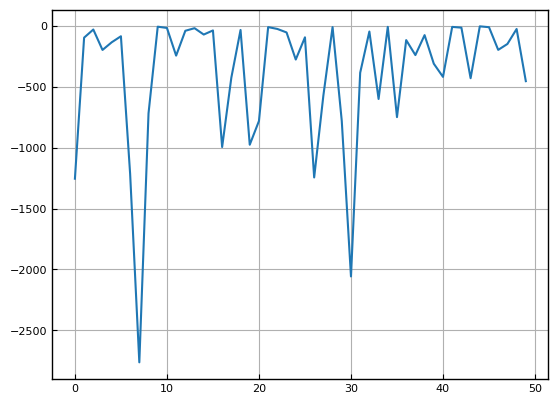

In [394]:
from scipy.signal import argrelextrema
from sklearn.neighbors import KernelDensity

# x = np.diff(a)
x = np.array(change_points, dtype=int)
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(x.reshape(-1, 1))
minval, maxval = 0, data_size - 1
s = np.linspace(minval, maxval)
e = kde.score_samples(s.reshape(-1, 1))
# display(list(zip(b, e)))
plt.plot(e)

mi = argrelextrema(e, np.less)[0]

clusters = []
if len(mi) <= 0:
    print("1 cluster")
    clusters.append(np.arange(len(x)))
else:
    clusters.append(np.where(x < s[mi][0])[0])  # most left cluster
    # all middle cluster
    for i_cluster in range(len(mi)-1):
        clusters.append(np.where((x >= s[mi][i_cluster]) * (x <= s[mi][i_cluster+1]))[0])
    clusters.append(np.where(x >= s[mi][-1])[0])  # most right cluster

print(clusters) 
x_indice_to_cluster_id = {x_indice: cluster_id for cluster_id, x_indices in enumerate(clusters) for x_indice in x_indices}
cluster_labels = np.array([x_indice_to_cluster_id[x_indice] for x_indice in range(len(x))])
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, x), columns=["metric", "cluster_id", "change_point"]).sort_values("change_point"))
cluster_id_to_metrics = {cluster_id: [metrics[x_indice] for x_indice in x_indices] for cluster_id, x_indices in enumerate(clusters)}

In [395]:
cluster_selection_epsilon = 3.0
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    min_samples=1,
    metric=lambda x, y: np.abs(x - y),
    allow_single_cluster=True,
    cluster_selection_method="leaf",
    cluster_selection_epsilon=cluster_selection_epsilon,
).fit(np.array([change_points]).T)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, clusterer.labels_, change_points, clusterer.outlier_scores_, clusterer.probabilities_), columns=["metric", "cluster_id", "change_point", "outlier_score", "probability"]))
print("persistence", clusterer.cluster_persistence_)


from dataclasses import dataclass
from collections import UserList


@dataclass
class ClusterMember:
    metric_name: str
    change_point: int
    proba: float

@dataclass
class Cluster:
    cluster_id: int  # -1 means a noise cluster
    centroid: int  # -1 means a noise cluster
    members: list[ClusterMember]

    @classmethod
    def from_raw_members(cls, cluster_id: int, centroid: int, members: list[tuple[str, int, float]]):
        return cls(cluster_id, centroid, [ClusterMember(*member) for member in members])

    def _has_near_members(self, target: ClusterMember, eps: int) -> bool:
        _members = sorted(self.members, key=lambda m: m.change_point)
        for _member in _members:
            if _member.change_point == target.change_point:
                continue
            if abs(_member.change_point - target.change_point) < eps:
                return True
        return False

    def _inliers(self, threshold: float = 0.0, eps: int = 1) -> list[ClusterMember]:
        assert 0 <= threshold <= 1
        return [m for m in self.members if m.proba >= threshold or self._has_near_members(m, eps)]
    
    def keep_only_inliers(self, threshold: float, eps: int) -> None:
        self.members = self._inliers(threshold, eps)
    
    def size(self) -> int:
        return len(self.members)


class Clusters(UserList[Cluster]):
    def __init__(self, clusters: list[Cluster]):
        super().__init__(UserList(clusters))

    @classmethod
    def from_raw_values(cls, clusterer: hdbscan.HDBSCAN, metrics: list[str], change_points: list[int]):
        _cluster_id_to_centroid = {
            cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
            for cluster_id in np.unique(clusterer.labels_)
            if cluster_id != -1  # skip noise cluster
        }
        _cluster_id_to_members = defaultdict(list)
        for label, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
            centroid: int = _cluster_id_to_centroid.get(label, -1)  # -1 means a noise cluster
            _cluster_id_to_members[(label, centroid)].append((metric, change_point, proba))

        clusters: list[Cluster] = []
        for (cluster_id, centroid), members in sorted(_cluster_id_to_members.items(), key=lambda x: x[0][1]):
            clusters.append(Cluster.from_raw_members(cluster_id, centroid, members))
        return Clusters(clusters)
    
    def inliner(self, threshold: float = 1.0, eps: int = 1, copy: bool = True):
        if copy:
            _orig_clusters = self.data
            return Clusters([Cluster(c.cluster_id, c.centroid, c._inliers(threshold=threshold, eps=eps)) for c in _orig_clusters if c.cluster_id != -1])
        else:
            for c in self:
                if c.cluster_id == -1:
                    self.data.remove(c)
                    continue
                c.keep_only_inliers(threshold=threshold, eps=eps)
            return self
    
    def cluster_of_max_size(self) -> Cluster:
        return max(self, key=lambda c: c.size())
    
    def noise(self) -> Cluster:
        return next(c for c in self.data if c.cluster_id == -1)
    

# cluster_id_to_centroid = {
#     cluster_id: clusterer.weighted_cluster_centroid(cluster_id)[0]
#     for cluster_id in np.unique(clusterer.labels_)
#     if cluster_id != -1  # skip noise cluster
# }
# cluster_id_to_change_points: dict[int, list[int]] = defaultdict(list)
# clusters_with_centroid: dict[tuple[int, int], list[str]] = defaultdict(list)
# # print(list(zip(clusterer.labels_, metrics, change_points)))
# for cluster_id, metric, change_point, proba in zip(clusterer.labels_, metrics, change_points, clusterer.probabilities_):
#     if cluster_id == -1:  # skip noise features
#         continue
#     centroid = cluster_id_to_centroid[cluster_id]
#     clusters_with_centroid[(cluster_id, centroid)].append(metric)
#     cluster_id_to_change_points[cluster_id].append(change_point)

# remove outliers
# for (cluster_id, centroid), members in clusters_with_centroid.items():
#     if proba <= 0.5 and :
#         continue
# # choose a cluster having max metrics and the adjacent clusters
# import pprint
# for x in clusters_with_centroid.items():
#     print(agglomerative_coefficient(np.array(cluster_id_to_change_points[x[0][0]], dtype=int), x[0][1]), x)

clusters = Clusters.from_raw_values(clusterer, metrics, change_points)
inliners = clusters.inliner(threshold=0.5, eps=int(cluster_selection_epsilon), copy=True)
# keep_clusters = [inliners.cluster_of_max_size()]
# print("keep_clusters", keep_clusters)

# keep_metrics: list[str] = [m.metric_name for m in keep_clusters[0].members]
# remove_metrics: list[str] = list(set(metrics) - set(keep_metrics))
# clustering_info: dict[str, list[str]] = {metric: [] for metric in keep_metrics}
# clustering_info, remove_metrics

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1379: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


metric  cluster_id  \
0          c-orders-db_cpu_cfs_throttled_periods_total          11   
1                  c-orders-db_cpu_usage_seconds_total          11   
2                           c-orders-db_fs_reads_total          11   
3                             c-orders-db_memory_cache          11   
4                               c-orders-db_memory_rss          11   
5                                c-orders-db_last_seen           1   
6                    c-orders-db_fs_writes_bytes_total          11   
7                   c-orders-db_cpu_user_seconds_total          11   
8                          c-orders-db_fs_writes_total          11   
9          c-orders-db_cpu_cfs_throttled_seconds_total          11   
10                    c-orders-db_fs_reads_bytes_total          11   
11                c-orders-db_memory_working_set_bytes          11   
12                   c-orders-db_cpu_cfs_periods_total          11   
13                c-orders-db_cpu_system_seconds_total          11   
14                c-orders-db_blkio_device_usage_total          11   
15            c-orders-db_network_transmit_bytes_total          11   
16             c-orders-db_network_receive_bytes_total          11   
17                      c-orders-db_memory_usage_bytes          11   
18                      c-orders-db_memory_mapped_file          11   
19          c-orders-db_network_transmit_packets_total          11   
20           c-orders-db_network_receive_packets_total          11   
21                                 c-orders-db_threads          11   
22   m-orders-db_mongodb_sys_netstat_TcpExt_TCPDSAC...           7   
23   m-orders-db_mongodb_ss_wt_log_log_sync_time_du...          11   
24   m-orders-db_mongodb_ss_wt_txn_sessions_scanned...          11   
25   m-orders-db_mongodb_ss_wt_cache_bytes_allocate...          11   
26   m-orders-db_mongodb_ss_wt_lock_metadata_lock_a...          11   
27   m-orders-db_mongodb_sys_mounts_etc_resolv_conf...           1   
28             m-orders-db_mongodb_sys_disks_sda_reads          11   
29   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...          11   
30   m-orders-db_mongodb_sys_netstat_TcpExt_Delayed...          11   
31   m-orders-db_mongodb_ss_wt_thread_yield_page_ac...          11   
32     m-orders-db_mongodb_ss_network_physicalBytesOut          11   
33   m-orders-db_mongodb_ss_wt_log_log_release_adva...          11   
34   m-orders-db_mongodb_ss_locks_Global_acquireCou...          11   
35        m-orders-db_mongodb_sys_disks_sda_io_time_ms          11   
36   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_total...          11   
37           m-orders-db_mongodb_sys_netstat_TcpExt_TW          11   
38                  m-orders-db_mongodb_ss_connections          11   
39   m-orders-db_mongodb_ss_wt_cache_eviction_serve...          11   
40   m-orders-db_mongodb_ss_extra_info_involuntary_...          11   
41               m-orders-db_mongodb_top_queries_count          11   
42           m-orders-db_mongodb_sys_cpu_procs_blocked          10   
43   m-orders-db_mongodb_ss_locks_Collection_acquir...          11   
44   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_centr...          11   
45   m-orders-db_mongodb_ss_wt_block_manager_bytes_...          11   
46            m-orders-db_mongodb_sys_memory_Active_kb          11   
47    m-orders-db_mongodb_ss_wt_txn_transaction_begins          11   
48   m-orders-db_mongodb_ss_wt_checkpoint_cleanup_p...          11   
49   m-orders-db_mongodb_ss_wt_block_manager_bytes_...          11   
50   m-orders-db_mongodb_ss_wt_connection_files_cur...          11   
51   m-orders-db_mongodb_ss_wt_txn_transaction_chec...          11   
52   m-orders-db_mongodb_sys_mounts_etc_hostname_av...           1   
53           m-orders-db_mongodb_sys_memory_MemFree_kb          11   
54   m-orders-db_mongodb_ss_wt_txn_transaction_fsyn...          11   
55   m-orders-db_mongodb_ss_wt_log_log_server_threa...          11   
56   m-orders-db_mongodb_ss_wt_lock_table_lock_inte...    

persistence [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [396]:
from scipy.signal import argrelextrema

# eps = 2/dataset.shape[0]
# a = np.sort(change_points)
# vfunc = np.vectorize(lambda x: 0 if x/dataset.shape[0] <= eps else x)
# diff = vfunc(np.diff(a))
# print("diff", diff)
# # rel_diff = [diff[i]/a[i] for i in range(len(diff))]
# # smoothed_a = interp1d(x=np.arange(0, len(diff)), y=diff, kind="cubic")(np.arange(0, len(diff)))
# # plt.plot(smoothed_a)
# seg_indices = argrelextrema(diff, np.greater)[0] + 2
# if abs(diff[0] - diff[1])/dataset.shape[0] > eps:
#     seg_indices = np.append(seg_indices, 1)
# if abs(diff[-1] - diff[-2])/dataset.shape[0] > eps:
#     seg_indices = np.append(seg_indices, len(diff))
# seg_indices = np.sort(seg_indices)
# print("segment", seg_indices)

# cluster_labels = []
# for label, clusters in enumerate(np.split(a, seg_indices)):
#     for _ in clusters:
#         cluster_labels.append(label)
# print(cluster_labels)
# with pd.option_context("display.max_rows", None, "display.max_columns", None):
#     display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

0 (0, 6)
1 (6, 14)
2 (14, 18)
3 (18, 34)
4 (34, 44)
5 (44, 46)
6 (46, 49)
7 (49, 51)
8 (51, 55)
9 (55, 66)
10 (66, 78)
11 (78, 80)
12 (80, 82)
13 (82, 86)
14 (86, 91)
15 (91, 103)
16 (103, 117)
17 (117, 125)
18 (125, 134)
19 (134, 141)
20 (141, 150)
21 (150, 154)
22 (154, 162)
23 (162, 166)
24 (166, 171)
25 (171, 175)
26 (175, 177)
[0, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 4, 4, 5, 6, 7, 8, 9, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 14, 15, 16, 17, 18, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 

metric  cluster_id  \
0          c-orders-db_cpu_cfs_throttled_periods_total           0   
1                  c-orders-db_cpu_usage_seconds_total           1   
2                           c-orders-db_fs_reads_total           1   
3                             c-orders-db_memory_cache           1   
4                               c-orders-db_memory_rss           1   
5                                c-orders-db_last_seen           1   
6                    c-orders-db_fs_writes_bytes_total           2   
7                   c-orders-db_cpu_user_seconds_total           2   
8                          c-orders-db_fs_writes_total           3   
9          c-orders-db_cpu_cfs_throttled_seconds_total           4   
10                    c-orders-db_fs_reads_bytes_total           4   
11                c-orders-db_memory_working_set_bytes           4   
12                   c-orders-db_cpu_cfs_periods_total           4   
13                c-orders-db_cpu_system_seconds_total           5   
14                c-orders-db_blkio_device_usage_total           6   
15            c-orders-db_network_transmit_bytes_total           7   
16             c-orders-db_network_receive_bytes_total           8   
17                      c-orders-db_memory_usage_bytes           9   
18                      c-orders-db_memory_mapped_file           9   
19          c-orders-db_network_transmit_packets_total          10   
20           c-orders-db_network_receive_packets_total          11   
21                                 c-orders-db_threads          11   
22   m-orders-db_mongodb_sys_netstat_TcpExt_TCPDSAC...          11   
23   m-orders-db_mongodb_ss_wt_log_log_sync_time_du...          11   
24   m-orders-db_mongodb_ss_wt_txn_sessions_scanned...          11   
25   m-orders-db_mongodb_ss_wt_cache_bytes_allocate...          11   
26   m-orders-db_mongodb_ss_wt_lock_metadata_lock_a...          11   
27   m-orders-db_mongodb_sys_mounts_etc_resolv_conf...          11   
28             m-orders-db_mongodb_sys_disks_sda_reads          11   
29   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_pageh...          11   
30   m-orders-db_mongodb_sys_netstat_TcpExt_Delayed...          11   
31   m-orders-db_mongodb_ss_wt_thread_yield_page_ac...          11   
32     m-orders-db_mongodb_ss_network_physicalBytesOut          11   
33   m-orders-db_mongodb_ss_wt_log_log_release_adva...          11   
34   m-orders-db_mongodb_ss_locks_Global_acquireCou...          12   
35        m-orders-db_mongodb_sys_disks_sda_io_time_ms          12   
36   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_total...          13   
37           m-orders-db_mongodb_sys_netstat_TcpExt_TW          14   
38                  m-orders-db_mongodb_ss_connections          15   
39   m-orders-db_mongodb_ss_wt_cache_eviction_serve...          16   
40   m-orders-db_mongodb_ss_extra_info_involuntary_...          17   
41               m-orders-db_mongodb_top_queries_count          18   
42           m-orders-db_mongodb_sys_cpu_procs_blocked          19   
43   m-orders-db_mongodb_ss_locks_Collection_acquir...          20   
44   m-orders-db_mongodb_ss_tcmalloc_tcmalloc_centr...          20   
45   m-orders-db_mongodb_ss_wt_block_manager_bytes_...          21   
46            m-orders-db_mongodb_sys_memory_Active_kb          21   
47    m-orders-db_mongodb_ss_wt_txn_transaction_begins          21   
48   m-orders-db_mongodb_ss_wt_checkpoint_cleanup_p...          22   
49   m-orders-db_mongodb_ss_wt_block_manager_bytes_...          22   
50   m-orders-db_mongodb_ss_wt_connection_files_cur...          22   
51   m-orders-db_mongodb_ss_wt_txn_transaction_chec...          22   
52   m-orders-db_mongodb_sys_mounts_etc_hostname_av...          22   
53           m-orders-db_mongodb_sys_memory_MemFree_kb          22   
54   m-orders-db_mongodb_ss_wt_txn_transaction_fsyn...          22   
55   m-orders-db_mongodb_ss_wt_log_log_server_threa...          22   
56   m-orders-db_mongodb_ss_wt_lock_table_lock_inte...    

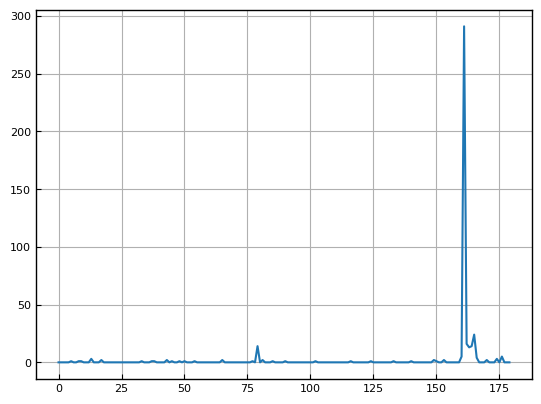

In [397]:
a = np.sort(np.array(change_points, dtype=int))

b = np.zeros(dataset.shape[0], dtype=int)
for i in range(b.size):
    indices = [_ for _ in a if _ == i]
    b[i] = len(indices)

plt.plot(b)
seg_indices = argrelextrema(b, np.greater)[0] + 1

cluster_labels = []
for label, indice in enumerate(seg_indices):
    if label == 0:
        left = 0
    else:
        left = seg_indices[label - 1]
    right = seg_indices[label]
    print(label, (left, right))
    clusters = np.where((a >= left) & (a < right))[0]
    for _ in clusters:
        cluster_labels.append(label)
print(cluster_labels)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.DataFrame(zip(metrics, cluster_labels, a), columns=["metric", "cluster_id", "change_point"]))

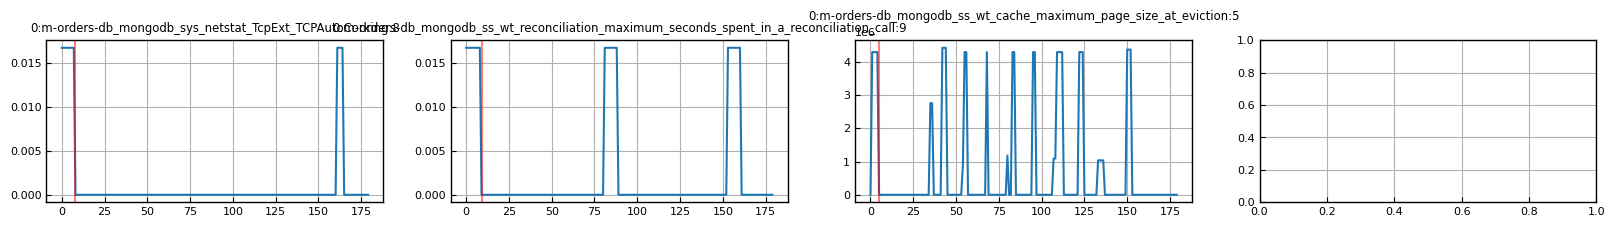

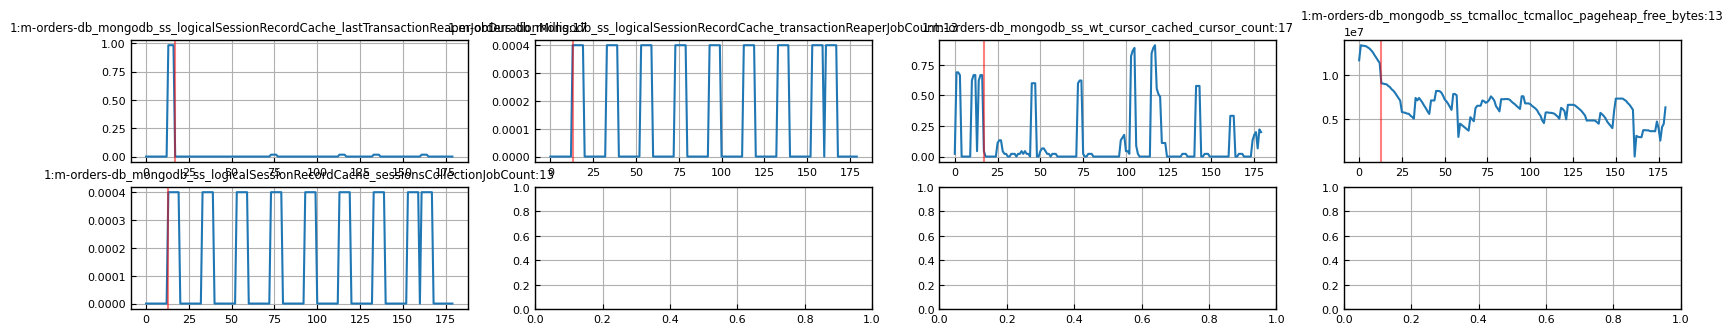

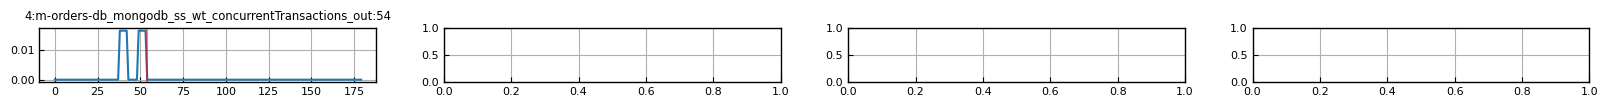

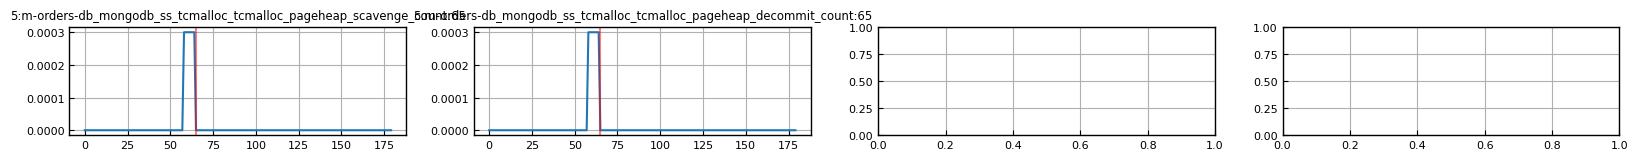

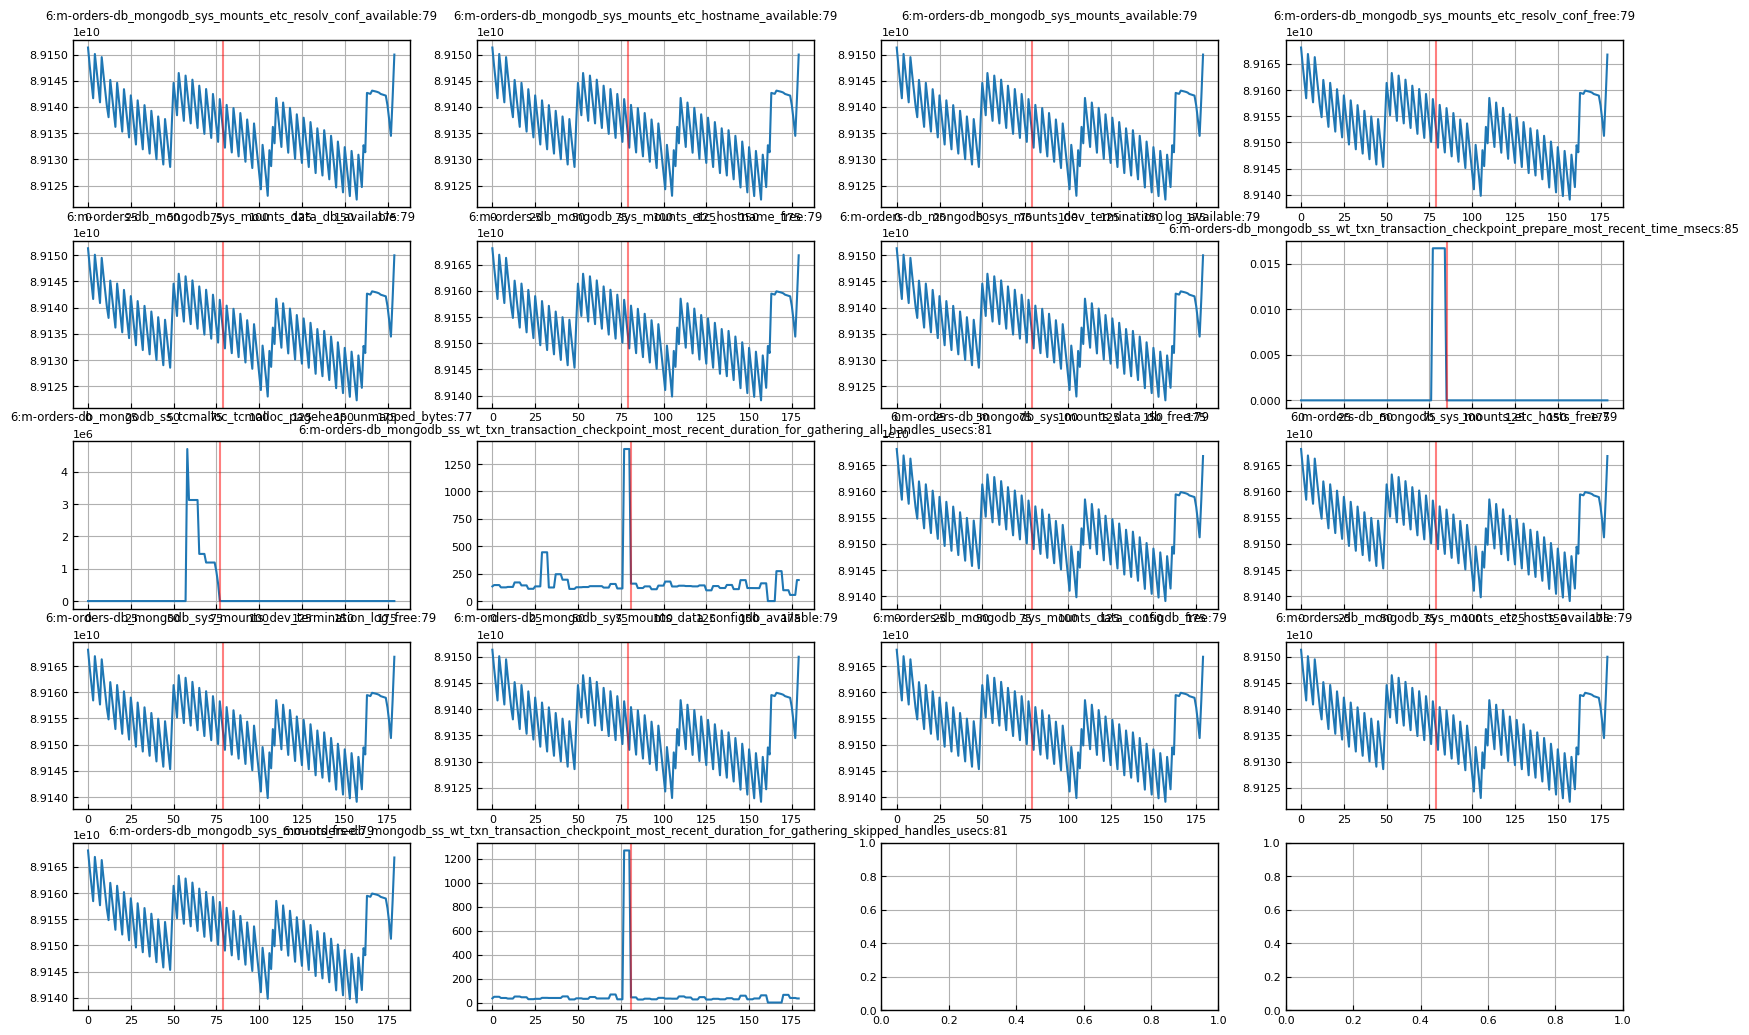

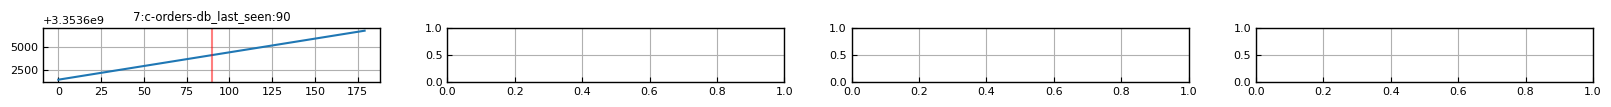

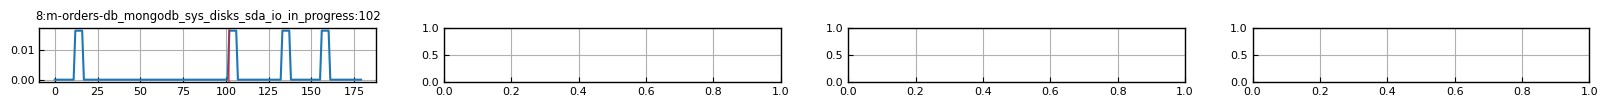

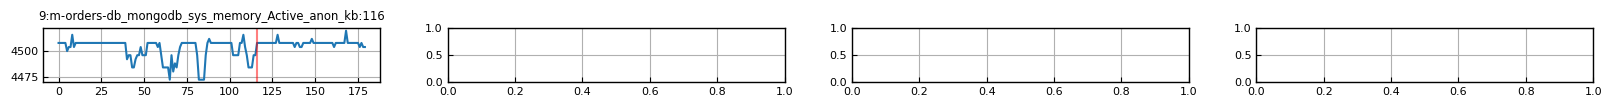

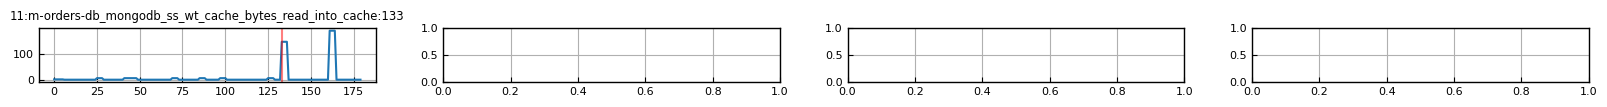

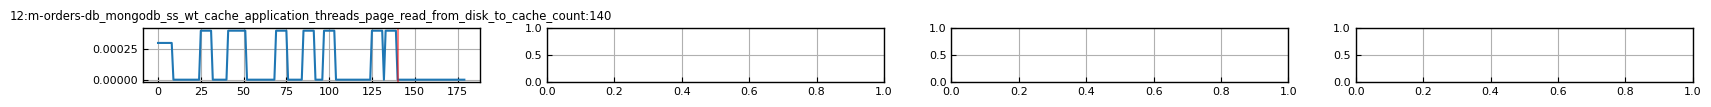

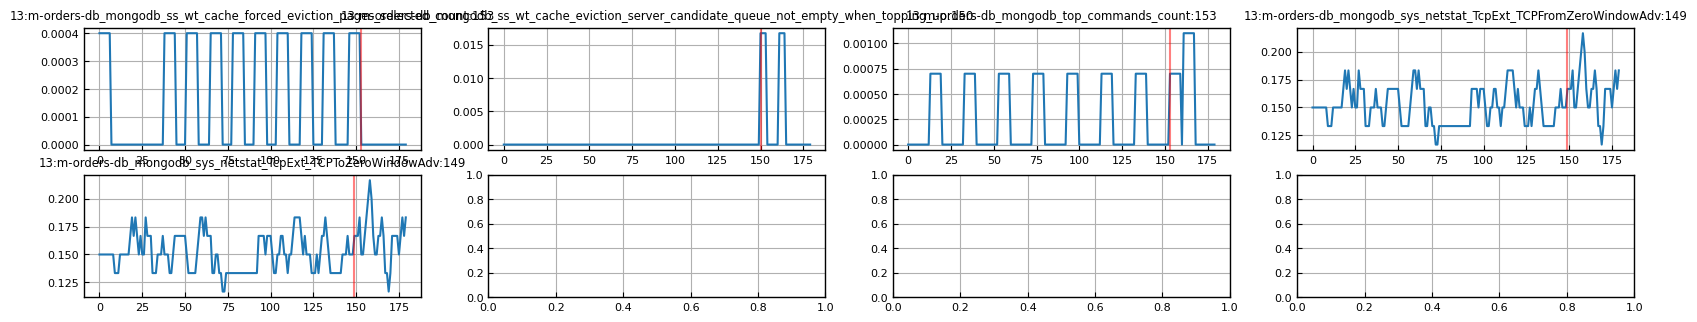

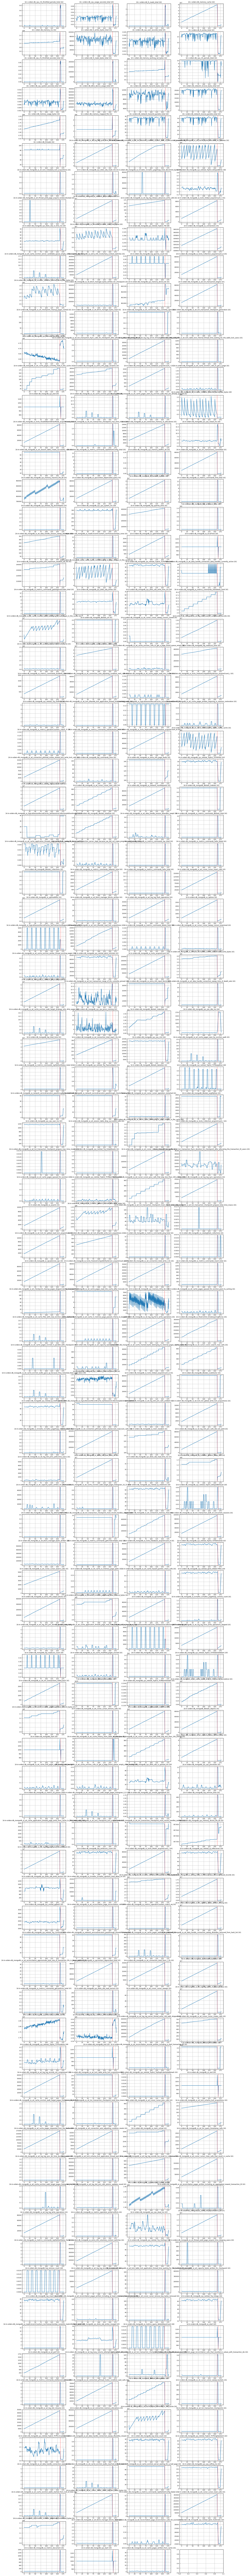

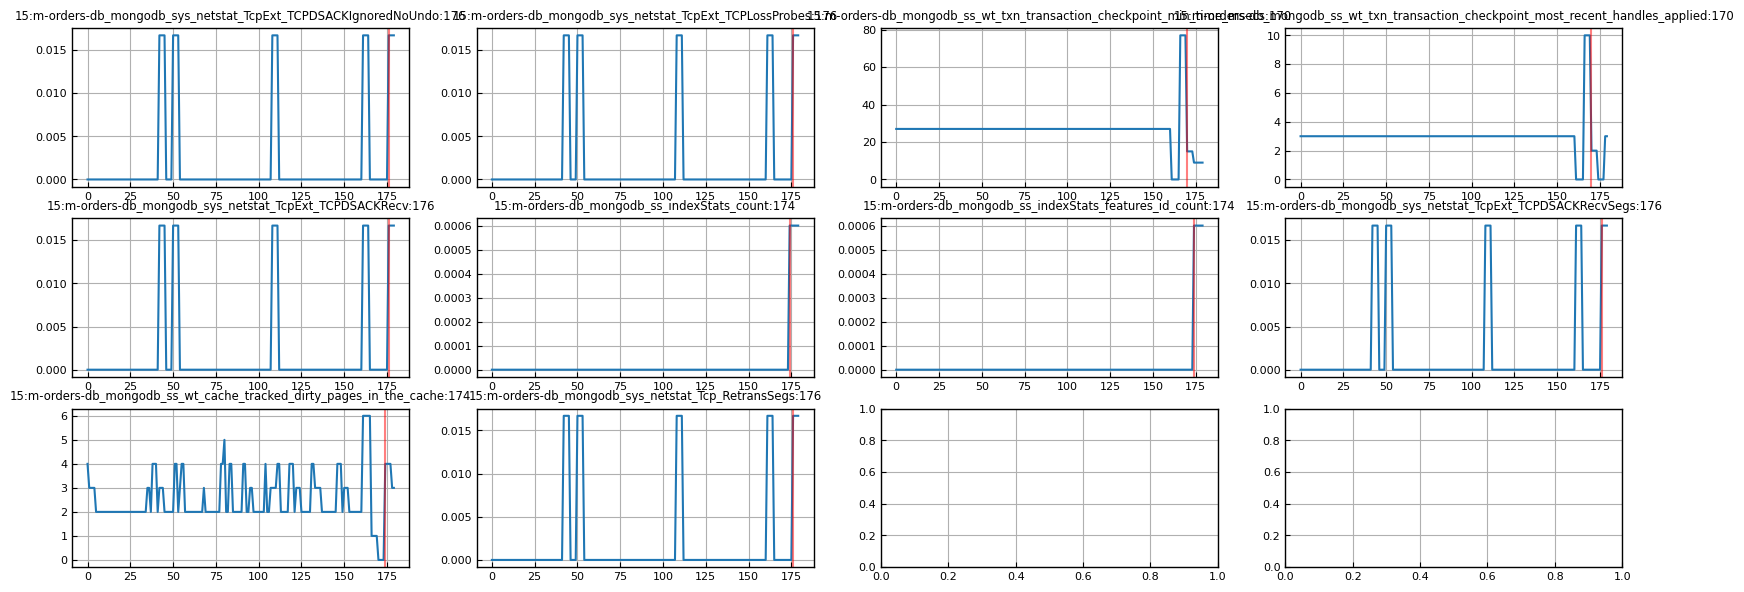

In [398]:
import math
from notebooklib import plot

plt.close()

for cluster_id, metrics in cluster_id_to_metrics.items():
    fig, axs = plt.subplots(math.ceil(len(metrics)/4), ncols=4)
    fig.set_size_inches(20, 0.7*len(metrics))
    for ax, member in zip(axs.flatten(), metrics):
        metric = member
        x = cause_dataset[metric].to_numpy()
        ax.plot(x)
        bkp = metric_to_bkp[metric]
        ax.axvline(bkp, color='red', alpha=0.5)
        ax.set_title(f"{cluster_id}:{metric}:{bkp}")